In [ ]:
import zipfile

zip_path = "/content/faces.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FaceDataset(Dataset):
    def __init__(self, root):
        self.samples = []
        for label, cls in enumerate(["real", "fake"]):
            for vid in os.listdir(f"{root}/{cls}"):
                for img in os.listdir(f"{root}/{cls}/{vid}"):
                    self.samples.append((f"{root}/{cls}/{vid}/{img}", label))

        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")
        return self.tf(img), label

In [ ]:
import timm
import torch.nn as nn
import os, cv2

DEVICE = "cuda"
BATCH_SIZE = 8
EPOCHS = 15
FACE_ROOT = "/content/content/faces"
dataset = FaceDataset(FACE_ROOT)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

class SwinDF(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",  # ✅ small & strong
            pretrained=True,
            num_classes=0
        )
        self.head = nn.Linear(self.backbone.num_features, 2)

    def forward(self, x):
        return self.head(self.backbone(x))

model = SwinDF().to(DEVICE)

# Freeze backbone
for p in model.backbone.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(model.head.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    correct = total = 0

    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    print(f"Epoch {epoch+1} Accuracy: {correct/total:.4f}")

Epoch 1/15: 100%|██████████| 2723/2723 [02:05<00:00, 21.71it/s]


Epoch 1 Accuracy: 0.7142


Epoch 2/15: 100%|██████████| 2723/2723 [02:01<00:00, 22.39it/s]


Epoch 2 Accuracy: 0.7715


Epoch 3/15: 100%|██████████| 2723/2723 [02:01<00:00, 22.34it/s]


Epoch 3 Accuracy: 0.7911


Epoch 4/15: 100%|██████████| 2723/2723 [02:02<00:00, 22.24it/s]


Epoch 4 Accuracy: 0.8019


Epoch 5/15: 100%|██████████| 2723/2723 [02:03<00:00, 22.11it/s]


Epoch 5 Accuracy: 0.8090


Epoch 6/15:  42%|████▏     | 1138/2723 [00:52<01:12, 21.87it/s]


KeyboardInterrupt: 

In [ ]:
# ================================
# SAVE TRAINED MODEL
# ================================
MODEL_PATH = "/content/swin_deepfake_detector.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epochs": EPOCHS
}, MODEL_PATH)

print(f"✅ Model saved at {MODEL_PATH}")

In [ ]:
# ================================
# STEP 0: IMPORTS & SETUP
# ================================
import os
import torch
import timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
EPOCHS = 15
DATA_ROOT = "/content/content/faces"

print("Using device:", DEVICE)

In [ ]:


# ================================
# STEP 1: DATASET CLASS
# ================================
class FaceDataset(Dataset):
    def __init__(self, root):
        self.samples = []

        for label, cls in enumerate(["real", "fake"]):
            cls_path = os.path.join(root, cls)
            if not os.path.exists(cls_path):
                raise ValueError(f"Missing folder: {cls_path}")

            for vid in os.listdir(cls_path):
                vid_path = os.path.join(cls_path, vid)
                if not os.path.isdir(vid_path):
                    continue

                for img in os.listdir(vid_path):
                    if img.lower().endswith((".jpg", ".png", ".jpeg")):
                        self.samples.append(
                            (os.path.join(vid_path, img), label)
                        )

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), label


In [ ]:

# ================================
# STEP 2: LOAD + SPLIT DATA
# ================================
dataset = FaceDataset(DATA_ROOT)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")


In [ ]:
# ================================
# STEP 3: MODEL (SWIN TRANSFORMER)
# ================================
class SwinDeepFake(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )
        self.head = nn.Linear(self.backbone.num_features, 2)

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

model = SwinDeepFake().to(DEVICE)

# Freeze backbone (recommended first)
for p in model.backbone.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.head.parameters(), lr=2e-4)


In [ ]:



# ================================
# STEP 4: TRAIN & VALIDATE
# ================================
best_val_acc = 0.0

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_correct = train_total = 0

    for x, y in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)

    train_acc = train_correct / train_total

    # ---- VALIDATE ----
    model.eval()
    val_correct = val_total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val   Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/swin_deepfake_best.pth")
        print("✅ Best model saved")

# ================================
# STEP 5: FINAL SAVE
# ================================
torch.save(model.state_dict(), "/content/swin_deepfake_final.pth")
print("🎉 Training complete")


Using device: cuda
Total samples found: 21783
Train samples: 17426
Val samples:   4357


Train Epoch 1/15: 100%|██████████| 2179/2179 [03:07<00:00, 11.63it/s]



Epoch 1
Train Accuracy: 0.6867
Val   Accuracy: 0.7604
✅ Best model saved


Train Epoch 2/15: 100%|██████████| 2179/2179 [03:13<00:00, 11.27it/s]



Epoch 2
Train Accuracy: 0.7538
Val   Accuracy: 0.7861
✅ Best model saved


Train Epoch 3/15: 100%|██████████| 2179/2179 [03:09<00:00, 11.48it/s]



Epoch 3
Train Accuracy: 0.7753
Val   Accuracy: 0.7914
✅ Best model saved


Train Epoch 4/15: 100%|██████████| 2179/2179 [03:09<00:00, 11.51it/s]



Epoch 4
Train Accuracy: 0.7846
Val   Accuracy: 0.8164
✅ Best model saved


Train Epoch 5/15: 100%|██████████| 2179/2179 [03:05<00:00, 11.73it/s]



Epoch 5
Train Accuracy: 0.7951
Val   Accuracy: 0.8134


Train Epoch 6/15: 100%|██████████| 2179/2179 [03:06<00:00, 11.67it/s]



Epoch 6
Train Accuracy: 0.8027
Val   Accuracy: 0.8269
✅ Best model saved


Train Epoch 7/15: 100%|██████████| 2179/2179 [03:06<00:00, 11.68it/s]



Epoch 7
Train Accuracy: 0.8128
Val   Accuracy: 0.8279
✅ Best model saved


Train Epoch 8/15: 100%|██████████| 2179/2179 [03:06<00:00, 11.68it/s]



Epoch 8
Train Accuracy: 0.8091
Val   Accuracy: 0.8299
✅ Best model saved


Train Epoch 9/15: 100%|██████████| 2179/2179 [03:07<00:00, 11.61it/s]



Epoch 9
Train Accuracy: 0.8160
Val   Accuracy: 0.8320
✅ Best model saved


Train Epoch 10/15: 100%|██████████| 2179/2179 [03:05<00:00, 11.75it/s]



Epoch 10
Train Accuracy: 0.8172
Val   Accuracy: 0.8380
✅ Best model saved


Train Epoch 11/15: 100%|██████████| 2179/2179 [03:05<00:00, 11.75it/s]



Epoch 11
Train Accuracy: 0.8189
Val   Accuracy: 0.8373


Train Epoch 12/15: 100%|██████████| 2179/2179 [03:07<00:00, 11.63it/s]



Epoch 12
Train Accuracy: 0.8215
Val   Accuracy: 0.8366


Train Epoch 13/15: 100%|██████████| 2179/2179 [03:06<00:00, 11.69it/s]



Epoch 13
Train Accuracy: 0.8224
Val   Accuracy: 0.8391
✅ Best model saved


Train Epoch 14/15: 100%|██████████| 2179/2179 [03:06<00:00, 11.70it/s]



Epoch 14
Train Accuracy: 0.8218
Val   Accuracy: 0.8405
✅ Best model saved


Train Epoch 15/15: 100%|██████████| 2179/2179 [03:09<00:00, 11.49it/s]



Epoch 15
Train Accuracy: 0.8264
Val   Accuracy: 0.8439
✅ Best model saved
🎉 Training complete


In [ ]:
import torch
import timm
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class SwinDF(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=False,
            num_classes=0
        )
        self.head = nn.Linear(self.backbone.num_features, 2)

    def forward(self, x):
        return self.head(self.backbone(x))

model = SwinDF().to(DEVICE)
model.load_state_dict(torch.load("/content/swin_deepfake_best.pth", map_location=DEVICE))
model.eval()

print("✅ Model loaded")

✅ Model loaded


In [ ]:
import cv2
import numpy as np
from retinaface import RetinaFace
from PIL import Image
from torchvision import transforms

IMG_SIZE = 224

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def extract_face_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("❌ Could not read image")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("❌ No face detected")

    # pick largest face (same as dataset)
    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2]-f["facial_area"][0]) *
                      (f["facial_area"][3]-f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]
    face_crop = img[y1:y2, x1:x2]

    if face_crop.size == 0:
        raise ValueError("❌ Empty face crop")

    face_crop = cv2.resize(face_crop, (IMG_SIZE, IMG_SIZE))
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    face_pil = Image.fromarray(face_crop)
    tensor = transform(face_pil).unsqueeze(0).to(DEVICE)

    return tensor


In [ ]:
import torch.nn.functional as F

def predict_image(img_path):
    x = extract_face_from_image(img_path)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)

    pred = probs.argmax(1).item()
    confidence = probs[0][pred].item()

    label = "FAKE" if pred == 1 else "REAL"
    return label, confidence

In [ ]:
img_path = "/content/Screenshot (580).png"  # 👈 put your image here

label, conf = predict_image(img_path)

print("Prediction :", label)
print("Confidence :", round(conf, 4))


Prediction : REAL
Confidence : 0.7061


In [ ]:
import os, random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class MappedFaceDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.real_dir = f"{root}/real"
        self.fake_dir = f"{root}/fake"

        self.real_ids = sorted(os.listdir(self.real_dir))
        self.fake_ids = sorted(os.listdir(self.fake_dir))

        self.samples = []

        # ---- FAKE PAIRS (real, fake) ----
        for fake_id in self.fake_ids:
            real_id = fake_id.split("_")[0]
            if real_id in self.real_ids:
                self.samples.append((real_id, fake_id, 1))  # FAKE

        # ---- REAL PAIRS (real, real) ----
        for rid in self.real_ids:
            self.samples.append((rid, rid, 0))  # REAL

        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def _load_random_face(self, folder):
        imgs = os.listdir(folder)
        img = random.choice(imgs)
        return self.tf(Image.open(f"{folder}/{img}").convert("RGB"))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        real_id, fake_id, label = self.samples[idx]

        img1 = self._load_random_face(f"{self.real_dir}/{real_id}")
        img2 = self._load_random_face(
            f"{self.fake_dir}/{fake_id}" if label == 1 else f"{self.real_dir}/{real_id}"
        )

        return img1, img2, label


In [ ]:
import timm, torch
import torch.nn as nn

class SiameseSwin(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )

        self.fc = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward_once(self, x):
        return self.backbone(x)

    def forward(self, x1, x2):
        f1 = self.forward_once(x1)
        f2 = self.forward_once(x2)
        diff = torch.abs(f1 - f2)
        return self.fc(diff)

In [ ]:
from torch.utils.data import DataLoader
import torch

DEVICE = "cuda"
BATCH_SIZE = 8
EPOCHS = 15

dataset = MappedFaceDataset("/content/content/faces")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SiameseSwin().to(DEVICE)

for p in model.backbone.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()


In [ ]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    correct = total = 0

    for x1, x2, y in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x1, x2, y = x1.to(DEVICE), x2.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x1, x2)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} Accuracy: {acc:.4f}")

torch.save(model.state_dict(), "/content/swin_siamese_mapping.pth")


Epoch 1/15: 100%|██████████| 250/250 [00:23<00:00, 10.70it/s]


Epoch 1 Accuracy: 0.5243


Epoch 2/15: 100%|██████████| 250/250 [00:23<00:00, 10.80it/s]


Epoch 2 Accuracy: 0.5418


Epoch 3/15: 100%|██████████| 250/250 [00:22<00:00, 10.92it/s]


Epoch 3 Accuracy: 0.5763


Epoch 4/15: 100%|██████████| 250/250 [00:22<00:00, 10.91it/s]


Epoch 4 Accuracy: 0.5683


Epoch 5/15: 100%|██████████| 250/250 [00:22<00:00, 10.89it/s]


Epoch 5 Accuracy: 0.5883


Epoch 6/15: 100%|██████████| 250/250 [00:22<00:00, 10.89it/s]


Epoch 6 Accuracy: 0.6023


Epoch 7/15: 100%|██████████| 250/250 [00:22<00:00, 10.97it/s]


Epoch 7 Accuracy: 0.6173


Epoch 8/15: 100%|██████████| 250/250 [00:22<00:00, 10.95it/s]


Epoch 8 Accuracy: 0.6198


Epoch 9/15: 100%|██████████| 250/250 [00:22<00:00, 10.93it/s]


Epoch 9 Accuracy: 0.6318


Epoch 10/15: 100%|██████████| 250/250 [00:22<00:00, 10.96it/s]


Epoch 10 Accuracy: 0.6183


Epoch 11/15: 100%|██████████| 250/250 [00:22<00:00, 10.94it/s]


Epoch 11 Accuracy: 0.6168


Epoch 12/15: 100%|██████████| 250/250 [00:22<00:00, 10.92it/s]


Epoch 12 Accuracy: 0.6393


Epoch 13/15: 100%|██████████| 250/250 [00:22<00:00, 10.89it/s]


Epoch 13 Accuracy: 0.6238


Epoch 14/15:  53%|█████▎    | 132/250 [00:12<00:10, 10.92it/s]


IsADirectoryError: [Errno 21] Is a directory: '/content/content/faces/fake/000_003/004_982'

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")
model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
)

img = Image.open("/content/fake_face.jpg").convert("RGB")
inputs = processor(img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

pred = outputs.logits.argmax(dim=1).item()
print("AI-generated" if pred == 1 else "Real")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

AI-generated


In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch.nn.functional as F

ai_processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

def detect_ai_generated(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = ai_processor(img, return_tensors="pt")

    with torch.no_grad():
        outputs = ai_model(**inputs)

    probs = F.softmax(outputs.logits, dim=1)
    ai_prob = probs[0][1].item()   # probability of AI-generated
    return ai_prob


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

In [ ]:
import torch
from transformers import SwinForImageClassification


In [ ]:
num_classes = 2  # real / fake

face_model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

SwinForImageClassification LOAD REPORT from: microsoft/swin-base-patch4-window7-224
Key               | Status   |                                                                                          
------------------+----------+------------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 1024]) vs model:torch.Size([2, 1024])
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([2])            

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [ ]:
!pip install timm

In [ ]:
import timm
import torch
import torch.nn as nn

In [ ]:
class SwinDeepfakeModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_base_patch4_window7_224",
            pretrained=False,   # weights come from .pth
            num_classes=0       # remove classifier
        )
        self.classifier = nn.Linear(
            self.backbone.num_features, num_classes
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
state_dict = torch.load(
    "/content/swin_deepfake_final.pth",
    map_location="cpu"
)

face_model = SwinDeepfakeModel(num_classes=2)
face_model.load_state_dict(state_dict, strict=True)
face_model.eval()

RuntimeError: Error(s) in loading state_dict for SwinDeepfakeModel:
	Missing key(s) in state_dict: "backbone.layers.2.blocks.6.norm1.weight", "backbone.layers.2.blocks.6.norm1.bias", "backbone.layers.2.blocks.6.attn.relative_position_bias_table", "backbone.layers.2.blocks.6.attn.qkv.weight", "backbone.layers.2.blocks.6.attn.qkv.bias", "backbone.layers.2.blocks.6.attn.proj.weight", "backbone.layers.2.blocks.6.attn.proj.bias", "backbone.layers.2.blocks.6.norm2.weight", "backbone.layers.2.blocks.6.norm2.bias", "backbone.layers.2.blocks.6.mlp.fc1.weight", "backbone.layers.2.blocks.6.mlp.fc1.bias", "backbone.layers.2.blocks.6.mlp.fc2.weight", "backbone.layers.2.blocks.6.mlp.fc2.bias", "backbone.layers.2.blocks.7.norm1.weight", "backbone.layers.2.blocks.7.norm1.bias", "backbone.layers.2.blocks.7.attn.relative_position_bias_table", "backbone.layers.2.blocks.7.attn.qkv.weight", "backbone.layers.2.blocks.7.attn.qkv.bias", "backbone.layers.2.blocks.7.attn.proj.weight", "backbone.layers.2.blocks.7.attn.proj.bias", "backbone.layers.2.blocks.7.norm2.weight", "backbone.layers.2.blocks.7.norm2.bias", "backbone.layers.2.blocks.7.mlp.fc1.weight", "backbone.layers.2.blocks.7.mlp.fc1.bias", "backbone.layers.2.blocks.7.mlp.fc2.weight", "backbone.layers.2.blocks.7.mlp.fc2.bias", "backbone.layers.2.blocks.8.norm1.weight", "backbone.layers.2.blocks.8.norm1.bias", "backbone.layers.2.blocks.8.attn.relative_position_bias_table", "backbone.layers.2.blocks.8.attn.qkv.weight", "backbone.layers.2.blocks.8.attn.qkv.bias", "backbone.layers.2.blocks.8.attn.proj.weight", "backbone.layers.2.blocks.8.attn.proj.bias", "backbone.layers.2.blocks.8.norm2.weight", "backbone.layers.2.blocks.8.norm2.bias", "backbone.layers.2.blocks.8.mlp.fc1.weight", "backbone.layers.2.blocks.8.mlp.fc1.bias", "backbone.layers.2.blocks.8.mlp.fc2.weight", "backbone.layers.2.blocks.8.mlp.fc2.bias", "backbone.layers.2.blocks.9.norm1.weight", "backbone.layers.2.blocks.9.norm1.bias", "backbone.layers.2.blocks.9.attn.relative_position_bias_table", "backbone.layers.2.blocks.9.attn.qkv.weight", "backbone.layers.2.blocks.9.attn.qkv.bias", "backbone.layers.2.blocks.9.attn.proj.weight", "backbone.layers.2.blocks.9.attn.proj.bias", "backbone.layers.2.blocks.9.norm2.weight", "backbone.layers.2.blocks.9.norm2.bias", "backbone.layers.2.blocks.9.mlp.fc1.weight", "backbone.layers.2.blocks.9.mlp.fc1.bias", "backbone.layers.2.blocks.9.mlp.fc2.weight", "backbone.layers.2.blocks.9.mlp.fc2.bias", "backbone.layers.2.blocks.10.norm1.weight", "backbone.layers.2.blocks.10.norm1.bias", "backbone.layers.2.blocks.10.attn.relative_position_bias_table", "backbone.layers.2.blocks.10.attn.qkv.weight", "backbone.layers.2.blocks.10.attn.qkv.bias", "backbone.layers.2.blocks.10.attn.proj.weight", "backbone.layers.2.blocks.10.attn.proj.bias", "backbone.layers.2.blocks.10.norm2.weight", "backbone.layers.2.blocks.10.norm2.bias", "backbone.layers.2.blocks.10.mlp.fc1.weight", "backbone.layers.2.blocks.10.mlp.fc1.bias", "backbone.layers.2.blocks.10.mlp.fc2.weight", "backbone.layers.2.blocks.10.mlp.fc2.bias", "backbone.layers.2.blocks.11.norm1.weight", "backbone.layers.2.blocks.11.norm1.bias", "backbone.layers.2.blocks.11.attn.relative_position_bias_table", "backbone.layers.2.blocks.11.attn.qkv.weight", "backbone.layers.2.blocks.11.attn.qkv.bias", "backbone.layers.2.blocks.11.attn.proj.weight", "backbone.layers.2.blocks.11.attn.proj.bias", "backbone.layers.2.blocks.11.norm2.weight", "backbone.layers.2.blocks.11.norm2.bias", "backbone.layers.2.blocks.11.mlp.fc1.weight", "backbone.layers.2.blocks.11.mlp.fc1.bias", "backbone.layers.2.blocks.11.mlp.fc2.weight", "backbone.layers.2.blocks.11.mlp.fc2.bias", "backbone.layers.2.blocks.12.norm1.weight", "backbone.layers.2.blocks.12.norm1.bias", "backbone.layers.2.blocks.12.attn.relative_position_bias_table", "backbone.layers.2.blocks.12.attn.qkv.weight", "backbone.layers.2.blocks.12.attn.qkv.bias", "backbone.layers.2.blocks.12.attn.proj.weight", "backbone.layers.2.blocks.12.attn.proj.bias", "backbone.layers.2.blocks.12.norm2.weight", "backbone.layers.2.blocks.12.norm2.bias", "backbone.layers.2.blocks.12.mlp.fc1.weight", "backbone.layers.2.blocks.12.mlp.fc1.bias", "backbone.layers.2.blocks.12.mlp.fc2.weight", "backbone.layers.2.blocks.12.mlp.fc2.bias", "backbone.layers.2.blocks.13.norm1.weight", "backbone.layers.2.blocks.13.norm1.bias", "backbone.layers.2.blocks.13.attn.relative_position_bias_table", "backbone.layers.2.blocks.13.attn.qkv.weight", "backbone.layers.2.blocks.13.attn.qkv.bias", "backbone.layers.2.blocks.13.attn.proj.weight", "backbone.layers.2.blocks.13.attn.proj.bias", "backbone.layers.2.blocks.13.norm2.weight", "backbone.layers.2.blocks.13.norm2.bias", "backbone.layers.2.blocks.13.mlp.fc1.weight", "backbone.layers.2.blocks.13.mlp.fc1.bias", "backbone.layers.2.blocks.13.mlp.fc2.weight", "backbone.layers.2.blocks.13.mlp.fc2.bias", "backbone.layers.2.blocks.14.norm1.weight", "backbone.layers.2.blocks.14.norm1.bias", "backbone.layers.2.blocks.14.attn.relative_position_bias_table", "backbone.layers.2.blocks.14.attn.qkv.weight", "backbone.layers.2.blocks.14.attn.qkv.bias", "backbone.layers.2.blocks.14.attn.proj.weight", "backbone.layers.2.blocks.14.attn.proj.bias", "backbone.layers.2.blocks.14.norm2.weight", "backbone.layers.2.blocks.14.norm2.bias", "backbone.layers.2.blocks.14.mlp.fc1.weight", "backbone.layers.2.blocks.14.mlp.fc1.bias", "backbone.layers.2.blocks.14.mlp.fc2.weight", "backbone.layers.2.blocks.14.mlp.fc2.bias", "backbone.layers.2.blocks.15.norm1.weight", "backbone.layers.2.blocks.15.norm1.bias", "backbone.layers.2.blocks.15.attn.relative_position_bias_table", "backbone.layers.2.blocks.15.attn.qkv.weight", "backbone.layers.2.blocks.15.attn.qkv.bias", "backbone.layers.2.blocks.15.attn.proj.weight", "backbone.layers.2.blocks.15.attn.proj.bias", "backbone.layers.2.blocks.15.norm2.weight", "backbone.layers.2.blocks.15.norm2.bias", "backbone.layers.2.blocks.15.mlp.fc1.weight", "backbone.layers.2.blocks.15.mlp.fc1.bias", "backbone.layers.2.blocks.15.mlp.fc2.weight", "backbone.layers.2.blocks.15.mlp.fc2.bias", "backbone.layers.2.blocks.16.norm1.weight", "backbone.layers.2.blocks.16.norm1.bias", "backbone.layers.2.blocks.16.attn.relative_position_bias_table", "backbone.layers.2.blocks.16.attn.qkv.weight", "backbone.layers.2.blocks.16.attn.qkv.bias", "backbone.layers.2.blocks.16.attn.proj.weight", "backbone.layers.2.blocks.16.attn.proj.bias", "backbone.layers.2.blocks.16.norm2.weight", "backbone.layers.2.blocks.16.norm2.bias", "backbone.layers.2.blocks.16.mlp.fc1.weight", "backbone.layers.2.blocks.16.mlp.fc1.bias", "backbone.layers.2.blocks.16.mlp.fc2.weight", "backbone.layers.2.blocks.16.mlp.fc2.bias", "backbone.layers.2.blocks.17.norm1.weight", "backbone.layers.2.blocks.17.norm1.bias", "backbone.layers.2.blocks.17.attn.relative_position_bias_table", "backbone.layers.2.blocks.17.attn.qkv.weight", "backbone.layers.2.blocks.17.attn.qkv.bias", "backbone.layers.2.blocks.17.attn.proj.weight", "backbone.layers.2.blocks.17.attn.proj.bias", "backbone.layers.2.blocks.17.norm2.weight", "backbone.layers.2.blocks.17.norm2.bias", "backbone.layers.2.blocks.17.mlp.fc1.weight", "backbone.layers.2.blocks.17.mlp.fc1.bias", "backbone.layers.2.blocks.17.mlp.fc2.weight", "backbone.layers.2.blocks.17.mlp.fc2.bias", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "head.weight", "head.bias". 
	size mismatch for backbone.patch_embed.proj.weight: copying a param with shape torch.Size([96, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 3, 4, 4]).
	size mismatch for backbone.patch_embed.proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.patch_embed.norm.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.patch_embed.norm.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 3]) from checkpoint, the shape in current model is torch.Size([169, 4]).
	size mismatch for backbone.layers.0.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([288, 96]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for backbone.layers.0.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.layers.0.blocks.0.attn.proj.weight: copying a param with shape torch.Size([96, 96]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for backbone.layers.0.blocks.0.attn.proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.norm2.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.norm2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([384, 96]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for backbone.layers.0.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.0.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([96, 384]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for backbone.layers.0.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 3]) from checkpoint, the shape in current model is torch.Size([169, 4]).
	size mismatch for backbone.layers.0.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([288, 96]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for backbone.layers.0.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.layers.0.blocks.1.attn.proj.weight: copying a param with shape torch.Size([96, 96]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for backbone.layers.0.blocks.1.attn.proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.norm2.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.norm2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.0.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([384, 96]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for backbone.layers.0.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.0.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([96, 384]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for backbone.layers.0.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.layers.1.downsample.norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.1.downsample.norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.1.downsample.reduction.weight: copying a param with shape torch.Size([192, 384]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for backbone.layers.1.blocks.0.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.0.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 6]) from checkpoint, the shape in current model is torch.Size([169, 8]).
	size mismatch for backbone.layers.1.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([576, 192]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for backbone.layers.1.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.layers.1.blocks.0.attn.proj.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for backbone.layers.1.blocks.0.attn.proj.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.0.norm2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.0.norm2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for backbone.layers.1.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.1.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for backbone.layers.1.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 6]) from checkpoint, the shape in current model is torch.Size([169, 8]).
	size mismatch for backbone.layers.1.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([576, 192]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for backbone.layers.1.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.layers.1.blocks.1.attn.proj.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for backbone.layers.1.blocks.1.attn.proj.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.norm2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.norm2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.1.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for backbone.layers.1.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.1.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for backbone.layers.1.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for backbone.layers.2.downsample.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.2.downsample.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.2.downsample.reduction.weight: copying a param with shape torch.Size([384, 768]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for backbone.layers.2.blocks.0.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.0.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.0.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.0.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.0.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.0.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.1.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.1.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.2.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.2.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.3.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.3.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.4.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.4.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 12]) from checkpoint, the shape in current model is torch.Size([169, 16]).
	size mismatch for backbone.layers.2.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for backbone.layers.2.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.layers.2.blocks.5.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for backbone.layers.2.blocks.5.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.2.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for backbone.layers.2.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.2.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for backbone.layers.2.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.layers.3.downsample.norm.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.3.downsample.norm.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for backbone.layers.3.downsample.reduction.weight: copying a param with shape torch.Size([768, 1536]) from checkpoint, the shape in current model is torch.Size([1024, 2048]).
	size mismatch for backbone.layers.3.blocks.0.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.0.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 24]) from checkpoint, the shape in current model is torch.Size([169, 32]).
	size mismatch for backbone.layers.3.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for backbone.layers.3.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.layers.3.blocks.0.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for backbone.layers.3.blocks.0.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.0.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.0.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for backbone.layers.3.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for backbone.layers.3.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for backbone.layers.3.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([169, 24]) from checkpoint, the shape in current model is torch.Size([169, 32]).
	size mismatch for backbone.layers.3.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for backbone.layers.3.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.layers.3.blocks.1.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for backbone.layers.3.blocks.1.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.layers.3.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for backbone.layers.3.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for backbone.layers.3.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for backbone.layers.3.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for backbone.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).

In [ ]:
import timm
import torch

face_model = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=2   # because head.weight exists
)

In [ ]:
state_dict = torch.load(
    "/content/swin_deepfake_final.pth",
    map_location="cpu"
)

face_model.load_state_dict(state_dict, strict=True)
face_model.eval()

RuntimeError: Error(s) in loading state_dict for SwinTransformer:
	Missing key(s) in state_dict: "patch_embed.proj.weight", "patch_embed.proj.bias", "patch_embed.norm.weight", "patch_embed.norm.bias", "layers.0.blocks.0.norm1.weight", "layers.0.blocks.0.norm1.bias", "layers.0.blocks.0.attn.relative_position_bias_table", "layers.0.blocks.0.attn.qkv.weight", "layers.0.blocks.0.attn.qkv.bias", "layers.0.blocks.0.attn.proj.weight", "layers.0.blocks.0.attn.proj.bias", "layers.0.blocks.0.norm2.weight", "layers.0.blocks.0.norm2.bias", "layers.0.blocks.0.mlp.fc1.weight", "layers.0.blocks.0.mlp.fc1.bias", "layers.0.blocks.0.mlp.fc2.weight", "layers.0.blocks.0.mlp.fc2.bias", "layers.0.blocks.1.norm1.weight", "layers.0.blocks.1.norm1.bias", "layers.0.blocks.1.attn.relative_position_bias_table", "layers.0.blocks.1.attn.qkv.weight", "layers.0.blocks.1.attn.qkv.bias", "layers.0.blocks.1.attn.proj.weight", "layers.0.blocks.1.attn.proj.bias", "layers.0.blocks.1.norm2.weight", "layers.0.blocks.1.norm2.bias", "layers.0.blocks.1.mlp.fc1.weight", "layers.0.blocks.1.mlp.fc1.bias", "layers.0.blocks.1.mlp.fc2.weight", "layers.0.blocks.1.mlp.fc2.bias", "layers.1.downsample.norm.weight", "layers.1.downsample.norm.bias", "layers.1.downsample.reduction.weight", "layers.1.blocks.0.norm1.weight", "layers.1.blocks.0.norm1.bias", "layers.1.blocks.0.attn.relative_position_bias_table", "layers.1.blocks.0.attn.qkv.weight", "layers.1.blocks.0.attn.qkv.bias", "layers.1.blocks.0.attn.proj.weight", "layers.1.blocks.0.attn.proj.bias", "layers.1.blocks.0.norm2.weight", "layers.1.blocks.0.norm2.bias", "layers.1.blocks.0.mlp.fc1.weight", "layers.1.blocks.0.mlp.fc1.bias", "layers.1.blocks.0.mlp.fc2.weight", "layers.1.blocks.0.mlp.fc2.bias", "layers.1.blocks.1.norm1.weight", "layers.1.blocks.1.norm1.bias", "layers.1.blocks.1.attn.relative_position_bias_table", "layers.1.blocks.1.attn.qkv.weight", "layers.1.blocks.1.attn.qkv.bias", "layers.1.blocks.1.attn.proj.weight", "layers.1.blocks.1.attn.proj.bias", "layers.1.blocks.1.norm2.weight", "layers.1.blocks.1.norm2.bias", "layers.1.blocks.1.mlp.fc1.weight", "layers.1.blocks.1.mlp.fc1.bias", "layers.1.blocks.1.mlp.fc2.weight", "layers.1.blocks.1.mlp.fc2.bias", "layers.2.downsample.norm.weight", "layers.2.downsample.norm.bias", "layers.2.downsample.reduction.weight", "layers.2.blocks.0.norm1.weight", "layers.2.blocks.0.norm1.bias", "layers.2.blocks.0.attn.relative_position_bias_table", "layers.2.blocks.0.attn.qkv.weight", "layers.2.blocks.0.attn.qkv.bias", "layers.2.blocks.0.attn.proj.weight", "layers.2.blocks.0.attn.proj.bias", "layers.2.blocks.0.norm2.weight", "layers.2.blocks.0.norm2.bias", "layers.2.blocks.0.mlp.fc1.weight", "layers.2.blocks.0.mlp.fc1.bias", "layers.2.blocks.0.mlp.fc2.weight", "layers.2.blocks.0.mlp.fc2.bias", "layers.2.blocks.1.norm1.weight", "layers.2.blocks.1.norm1.bias", "layers.2.blocks.1.attn.relative_position_bias_table", "layers.2.blocks.1.attn.qkv.weight", "layers.2.blocks.1.attn.qkv.bias", "layers.2.blocks.1.attn.proj.weight", "layers.2.blocks.1.attn.proj.bias", "layers.2.blocks.1.norm2.weight", "layers.2.blocks.1.norm2.bias", "layers.2.blocks.1.mlp.fc1.weight", "layers.2.blocks.1.mlp.fc1.bias", "layers.2.blocks.1.mlp.fc2.weight", "layers.2.blocks.1.mlp.fc2.bias", "layers.2.blocks.2.norm1.weight", "layers.2.blocks.2.norm1.bias", "layers.2.blocks.2.attn.relative_position_bias_table", "layers.2.blocks.2.attn.qkv.weight", "layers.2.blocks.2.attn.qkv.bias", "layers.2.blocks.2.attn.proj.weight", "layers.2.blocks.2.attn.proj.bias", "layers.2.blocks.2.norm2.weight", "layers.2.blocks.2.norm2.bias", "layers.2.blocks.2.mlp.fc1.weight", "layers.2.blocks.2.mlp.fc1.bias", "layers.2.blocks.2.mlp.fc2.weight", "layers.2.blocks.2.mlp.fc2.bias", "layers.2.blocks.3.norm1.weight", "layers.2.blocks.3.norm1.bias", "layers.2.blocks.3.attn.relative_position_bias_table", "layers.2.blocks.3.attn.qkv.weight", "layers.2.blocks.3.attn.qkv.bias", "layers.2.blocks.3.attn.proj.weight", "layers.2.blocks.3.attn.proj.bias", "layers.2.blocks.3.norm2.weight", "layers.2.blocks.3.norm2.bias", "layers.2.blocks.3.mlp.fc1.weight", "layers.2.blocks.3.mlp.fc1.bias", "layers.2.blocks.3.mlp.fc2.weight", "layers.2.blocks.3.mlp.fc2.bias", "layers.2.blocks.4.norm1.weight", "layers.2.blocks.4.norm1.bias", "layers.2.blocks.4.attn.relative_position_bias_table", "layers.2.blocks.4.attn.qkv.weight", "layers.2.blocks.4.attn.qkv.bias", "layers.2.blocks.4.attn.proj.weight", "layers.2.blocks.4.attn.proj.bias", "layers.2.blocks.4.norm2.weight", "layers.2.blocks.4.norm2.bias", "layers.2.blocks.4.mlp.fc1.weight", "layers.2.blocks.4.mlp.fc1.bias", "layers.2.blocks.4.mlp.fc2.weight", "layers.2.blocks.4.mlp.fc2.bias", "layers.2.blocks.5.norm1.weight", "layers.2.blocks.5.norm1.bias", "layers.2.blocks.5.attn.relative_position_bias_table", "layers.2.blocks.5.attn.qkv.weight", "layers.2.blocks.5.attn.qkv.bias", "layers.2.blocks.5.attn.proj.weight", "layers.2.blocks.5.attn.proj.bias", "layers.2.blocks.5.norm2.weight", "layers.2.blocks.5.norm2.bias", "layers.2.blocks.5.mlp.fc1.weight", "layers.2.blocks.5.mlp.fc1.bias", "layers.2.blocks.5.mlp.fc2.weight", "layers.2.blocks.5.mlp.fc2.bias", "layers.3.downsample.norm.weight", "layers.3.downsample.norm.bias", "layers.3.downsample.reduction.weight", "layers.3.blocks.0.norm1.weight", "layers.3.blocks.0.norm1.bias", "layers.3.blocks.0.attn.relative_position_bias_table", "layers.3.blocks.0.attn.qkv.weight", "layers.3.blocks.0.attn.qkv.bias", "layers.3.blocks.0.attn.proj.weight", "layers.3.blocks.0.attn.proj.bias", "layers.3.blocks.0.norm2.weight", "layers.3.blocks.0.norm2.bias", "layers.3.blocks.0.mlp.fc1.weight", "layers.3.blocks.0.mlp.fc1.bias", "layers.3.blocks.0.mlp.fc2.weight", "layers.3.blocks.0.mlp.fc2.bias", "layers.3.blocks.1.norm1.weight", "layers.3.blocks.1.norm1.bias", "layers.3.blocks.1.attn.relative_position_bias_table", "layers.3.blocks.1.attn.qkv.weight", "layers.3.blocks.1.attn.qkv.bias", "layers.3.blocks.1.attn.proj.weight", "layers.3.blocks.1.attn.proj.bias", "layers.3.blocks.1.norm2.weight", "layers.3.blocks.1.norm2.bias", "layers.3.blocks.1.mlp.fc1.weight", "layers.3.blocks.1.mlp.fc1.bias", "layers.3.blocks.1.mlp.fc2.weight", "layers.3.blocks.1.mlp.fc2.bias", "norm.weight", "norm.bias", "head.fc.weight", "head.fc.bias". 
	Unexpected key(s) in state_dict: "backbone.patch_embed.proj.weight", "backbone.patch_embed.proj.bias", "backbone.patch_embed.norm.weight", "backbone.patch_embed.norm.bias", "backbone.layers.0.blocks.0.norm1.weight", "backbone.layers.0.blocks.0.norm1.bias", "backbone.layers.0.blocks.0.attn.relative_position_bias_table", "backbone.layers.0.blocks.0.attn.qkv.weight", "backbone.layers.0.blocks.0.attn.qkv.bias", "backbone.layers.0.blocks.0.attn.proj.weight", "backbone.layers.0.blocks.0.attn.proj.bias", "backbone.layers.0.blocks.0.norm2.weight", "backbone.layers.0.blocks.0.norm2.bias", "backbone.layers.0.blocks.0.mlp.fc1.weight", "backbone.layers.0.blocks.0.mlp.fc1.bias", "backbone.layers.0.blocks.0.mlp.fc2.weight", "backbone.layers.0.blocks.0.mlp.fc2.bias", "backbone.layers.0.blocks.1.norm1.weight", "backbone.layers.0.blocks.1.norm1.bias", "backbone.layers.0.blocks.1.attn.relative_position_bias_table", "backbone.layers.0.blocks.1.attn.qkv.weight", "backbone.layers.0.blocks.1.attn.qkv.bias", "backbone.layers.0.blocks.1.attn.proj.weight", "backbone.layers.0.blocks.1.attn.proj.bias", "backbone.layers.0.blocks.1.norm2.weight", "backbone.layers.0.blocks.1.norm2.bias", "backbone.layers.0.blocks.1.mlp.fc1.weight", "backbone.layers.0.blocks.1.mlp.fc1.bias", "backbone.layers.0.blocks.1.mlp.fc2.weight", "backbone.layers.0.blocks.1.mlp.fc2.bias", "backbone.layers.1.downsample.norm.weight", "backbone.layers.1.downsample.norm.bias", "backbone.layers.1.downsample.reduction.weight", "backbone.layers.1.blocks.0.norm1.weight", "backbone.layers.1.blocks.0.norm1.bias", "backbone.layers.1.blocks.0.attn.relative_position_bias_table", "backbone.layers.1.blocks.0.attn.qkv.weight", "backbone.layers.1.blocks.0.attn.qkv.bias", "backbone.layers.1.blocks.0.attn.proj.weight", "backbone.layers.1.blocks.0.attn.proj.bias", "backbone.layers.1.blocks.0.norm2.weight", "backbone.layers.1.blocks.0.norm2.bias", "backbone.layers.1.blocks.0.mlp.fc1.weight", "backbone.layers.1.blocks.0.mlp.fc1.bias", "backbone.layers.1.blocks.0.mlp.fc2.weight", "backbone.layers.1.blocks.0.mlp.fc2.bias", "backbone.layers.1.blocks.1.norm1.weight", "backbone.layers.1.blocks.1.norm1.bias", "backbone.layers.1.blocks.1.attn.relative_position_bias_table", "backbone.layers.1.blocks.1.attn.qkv.weight", "backbone.layers.1.blocks.1.attn.qkv.bias", "backbone.layers.1.blocks.1.attn.proj.weight", "backbone.layers.1.blocks.1.attn.proj.bias", "backbone.layers.1.blocks.1.norm2.weight", "backbone.layers.1.blocks.1.norm2.bias", "backbone.layers.1.blocks.1.mlp.fc1.weight", "backbone.layers.1.blocks.1.mlp.fc1.bias", "backbone.layers.1.blocks.1.mlp.fc2.weight", "backbone.layers.1.blocks.1.mlp.fc2.bias", "backbone.layers.2.downsample.norm.weight", "backbone.layers.2.downsample.norm.bias", "backbone.layers.2.downsample.reduction.weight", "backbone.layers.2.blocks.0.norm1.weight", "backbone.layers.2.blocks.0.norm1.bias", "backbone.layers.2.blocks.0.attn.relative_position_bias_table", "backbone.layers.2.blocks.0.attn.qkv.weight", "backbone.layers.2.blocks.0.attn.qkv.bias", "backbone.layers.2.blocks.0.attn.proj.weight", "backbone.layers.2.blocks.0.attn.proj.bias", "backbone.layers.2.blocks.0.norm2.weight", "backbone.layers.2.blocks.0.norm2.bias", "backbone.layers.2.blocks.0.mlp.fc1.weight", "backbone.layers.2.blocks.0.mlp.fc1.bias", "backbone.layers.2.blocks.0.mlp.fc2.weight", "backbone.layers.2.blocks.0.mlp.fc2.bias", "backbone.layers.2.blocks.1.norm1.weight", "backbone.layers.2.blocks.1.norm1.bias", "backbone.layers.2.blocks.1.attn.relative_position_bias_table", "backbone.layers.2.blocks.1.attn.qkv.weight", "backbone.layers.2.blocks.1.attn.qkv.bias", "backbone.layers.2.blocks.1.attn.proj.weight", "backbone.layers.2.blocks.1.attn.proj.bias", "backbone.layers.2.blocks.1.norm2.weight", "backbone.layers.2.blocks.1.norm2.bias", "backbone.layers.2.blocks.1.mlp.fc1.weight", "backbone.layers.2.blocks.1.mlp.fc1.bias", "backbone.layers.2.blocks.1.mlp.fc2.weight", "backbone.layers.2.blocks.1.mlp.fc2.bias", "backbone.layers.2.blocks.2.norm1.weight", "backbone.layers.2.blocks.2.norm1.bias", "backbone.layers.2.blocks.2.attn.relative_position_bias_table", "backbone.layers.2.blocks.2.attn.qkv.weight", "backbone.layers.2.blocks.2.attn.qkv.bias", "backbone.layers.2.blocks.2.attn.proj.weight", "backbone.layers.2.blocks.2.attn.proj.bias", "backbone.layers.2.blocks.2.norm2.weight", "backbone.layers.2.blocks.2.norm2.bias", "backbone.layers.2.blocks.2.mlp.fc1.weight", "backbone.layers.2.blocks.2.mlp.fc1.bias", "backbone.layers.2.blocks.2.mlp.fc2.weight", "backbone.layers.2.blocks.2.mlp.fc2.bias", "backbone.layers.2.blocks.3.norm1.weight", "backbone.layers.2.blocks.3.norm1.bias", "backbone.layers.2.blocks.3.attn.relative_position_bias_table", "backbone.layers.2.blocks.3.attn.qkv.weight", "backbone.layers.2.blocks.3.attn.qkv.bias", "backbone.layers.2.blocks.3.attn.proj.weight", "backbone.layers.2.blocks.3.attn.proj.bias", "backbone.layers.2.blocks.3.norm2.weight", "backbone.layers.2.blocks.3.norm2.bias", "backbone.layers.2.blocks.3.mlp.fc1.weight", "backbone.layers.2.blocks.3.mlp.fc1.bias", "backbone.layers.2.blocks.3.mlp.fc2.weight", "backbone.layers.2.blocks.3.mlp.fc2.bias", "backbone.layers.2.blocks.4.norm1.weight", "backbone.layers.2.blocks.4.norm1.bias", "backbone.layers.2.blocks.4.attn.relative_position_bias_table", "backbone.layers.2.blocks.4.attn.qkv.weight", "backbone.layers.2.blocks.4.attn.qkv.bias", "backbone.layers.2.blocks.4.attn.proj.weight", "backbone.layers.2.blocks.4.attn.proj.bias", "backbone.layers.2.blocks.4.norm2.weight", "backbone.layers.2.blocks.4.norm2.bias", "backbone.layers.2.blocks.4.mlp.fc1.weight", "backbone.layers.2.blocks.4.mlp.fc1.bias", "backbone.layers.2.blocks.4.mlp.fc2.weight", "backbone.layers.2.blocks.4.mlp.fc2.bias", "backbone.layers.2.blocks.5.norm1.weight", "backbone.layers.2.blocks.5.norm1.bias", "backbone.layers.2.blocks.5.attn.relative_position_bias_table", "backbone.layers.2.blocks.5.attn.qkv.weight", "backbone.layers.2.blocks.5.attn.qkv.bias", "backbone.layers.2.blocks.5.attn.proj.weight", "backbone.layers.2.blocks.5.attn.proj.bias", "backbone.layers.2.blocks.5.norm2.weight", "backbone.layers.2.blocks.5.norm2.bias", "backbone.layers.2.blocks.5.mlp.fc1.weight", "backbone.layers.2.blocks.5.mlp.fc1.bias", "backbone.layers.2.blocks.5.mlp.fc2.weight", "backbone.layers.2.blocks.5.mlp.fc2.bias", "backbone.layers.3.downsample.norm.weight", "backbone.layers.3.downsample.norm.bias", "backbone.layers.3.downsample.reduction.weight", "backbone.layers.3.blocks.0.norm1.weight", "backbone.layers.3.blocks.0.norm1.bias", "backbone.layers.3.blocks.0.attn.relative_position_bias_table", "backbone.layers.3.blocks.0.attn.qkv.weight", "backbone.layers.3.blocks.0.attn.qkv.bias", "backbone.layers.3.blocks.0.attn.proj.weight", "backbone.layers.3.blocks.0.attn.proj.bias", "backbone.layers.3.blocks.0.norm2.weight", "backbone.layers.3.blocks.0.norm2.bias", "backbone.layers.3.blocks.0.mlp.fc1.weight", "backbone.layers.3.blocks.0.mlp.fc1.bias", "backbone.layers.3.blocks.0.mlp.fc2.weight", "backbone.layers.3.blocks.0.mlp.fc2.bias", "backbone.layers.3.blocks.1.norm1.weight", "backbone.layers.3.blocks.1.norm1.bias", "backbone.layers.3.blocks.1.attn.relative_position_bias_table", "backbone.layers.3.blocks.1.attn.qkv.weight", "backbone.layers.3.blocks.1.attn.qkv.bias", "backbone.layers.3.blocks.1.attn.proj.weight", "backbone.layers.3.blocks.1.attn.proj.bias", "backbone.layers.3.blocks.1.norm2.weight", "backbone.layers.3.blocks.1.norm2.bias", "backbone.layers.3.blocks.1.mlp.fc1.weight", "backbone.layers.3.blocks.1.mlp.fc1.bias", "backbone.layers.3.blocks.1.mlp.fc2.weight", "backbone.layers.3.blocks.1.mlp.fc2.bias", "backbone.norm.weight", "backbone.norm.bias", "head.weight", "head.bias". 

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch
import torch.nn.functional as F

ai_processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

def detect_ai_generated(img_path):
    img = Image.open(img_path).convert("RGB")
    inputs = ai_processor(img, return_tensors="pt")

    with torch.no_grad():
        outputs = ai_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)

    ai_prob = probs[0][1].item()   # class 1 = AI
    return ai_prob


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

In [ ]:
!pip install retina-face

In [ ]:
import cv2
import numpy as np
from retinaface import RetinaFace
from torchvision import transforms
from PIL import Image

IMG_SIZE = 224
DEVICE = "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def extract_face_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("❌ Could not read image")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("❌ No face detected")

    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2]-f["facial_area"][0]) *
                      (f["facial_area"][3]-f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]
    face_crop = img[y1:y2, x1:x2]

    face_crop = cv2.resize(face_crop, (IMG_SIZE, IMG_SIZE))
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    face_pil = Image.fromarray(face_crop)
    tensor = transform(face_pil).unsqueeze(0).to(DEVICE)

    return tensor


def detect_face_swap(img_path):
    x = extract_face_from_image(img_path)

    with torch.no_grad():
        logits = face_model(x)
        probs = F.softmax(logits, dim=1)

    face_fake_prob = probs[0][1].item()  # class 1 = fake
    return face_fake_prob

In [ ]:
def predict_image_final(img_path,
                        ai_thresh=0.6,
                        face_thresh=0.6):

    ai_prob = detect_ai_generated(img_path)

    try:
        face_prob = detect_face_swap(img_path)
    except:
        face_prob = 0.0  # no face → rely on AI detector

    is_fake = (ai_prob > ai_thresh) or (face_prob > face_thresh)

    return {
        "final_label": "FAKE" if is_fake else "REAL",
        "ai_generated_prob": round(ai_prob, 4),
        "face_swap_prob": round(face_prob, 4)
    }

In [ ]:
img_path = "/content/face_swap-2.jpg"

result = predict_image_final(img_path)

print("Final Prediction :", result["final_label"])
print("AI-generated prob:", result["ai_generated_prob"])
print("Face-swap prob   :", result["face_swap_prob"])

Final Prediction : REAL
AI-generated prob: 0.1805
Face-swap prob   : 0.4284


In [ ]:
import cv2
from retinaface import RetinaFace
from PIL import Image

IMG_SIZE = 224

def extract_face_pil(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Could not read image")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("No face detected")

    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2] - f["facial_area"][0]) *
                      (f["facial_area"][3] - f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]
    face_crop = img[y1:y2, x1:x2]

    face_crop = cv2.resize(face_crop, (IMG_SIZE, IMG_SIZE))
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    return Image.fromarray(face_crop)


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import torch.nn.functional as F

ai_processor = AutoImageProcessor.from_pretrained(
    "umm-maybe/AI-image-detector"
)
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

def detect_ai_generated_face(img_path):
    face_pil = extract_face_pil(img_path)

    inputs = ai_processor(
        face_pil,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = ai_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)

    return probs[0][1].item()  # class 1 = AI

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/348M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

In [ ]:
def predict(img_path, threshold=0.7):
    ai_prob = detect_ai_generated_face(img_path)

    label = "AI-GENERATED" if ai_prob > threshold else "REAL"

    print("Prediction :", label)
    print("AI Probability :", round(ai_prob, 4))


In [ ]:
predict("/content/WhatsApp Image 2026-02-06 at 11.33.04 AM.jpeg")

Prediction : AI-GENERATED
AI Probability : 0.9938


In [ ]:
import cv2
from retinaface import RetinaFace
from PIL import Image

def extract_face_pil(img_path, pad=40):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("No face detected")

    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2]-f["facial_area"][0]) *
                      (f["facial_area"][3]-f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]

    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(img.shape[1], x2 + pad)
    y2 = min(img.shape[0], y2 + pad)

    face_crop = img[y1:y2, x1:x2]
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    return Image.fromarray(face_crop)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained(
    "microsoft/swin-base-patch4-window7-224"
)

backbone = AutoModel.from_pretrained(
    "microsoft/swin-base-patch4-window7-224"
)

class SwinAIDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(1024, 2)  # REAL / AI

    def forward(self, x):
        out = self.backbone(pixel_values=x)
        feat = out.pooler_output
        return self.classifier(feat)

model = SwinAIDetector().to(DEVICE).eval()

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/447 [00:00<?, ?it/s]

SwinModel LOAD REPORT from: microsoft/swin-base-patch4-window7-224
Key               | Status     |  | 
------------------+------------+--+-
classifier.weight | UNEXPECTED |  | 
classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
def detect_ai_generated_face(img_path):
    face = extract_face_pil(img_path)

    inputs = processor(
        face,
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs)
        probs = F.softmax(logits, dim=1)

    ai_prob = probs[0][1].item()
    label = "AI" if ai_prob > 0.75 else "REAL"

    return label, round(ai_prob, 4)

In [ ]:
def predict(img_path, threshold=0.7):
    ai_prob = detect_ai_generated_face(img_path)

    label = "AI-GENERATED" if ai_prob > threshold else "REAL"

    print("Prediction :", label)
    print("AI Probability :", round(ai_prob, 4))


In [ ]:
predict("/content/WhatsApp Image 2026-02-06 at 11.33.04 AM.jpeg")

TypeError: SwinAIDetector.forward() got an unexpected keyword argument 'pixel_values'

In [ ]:
pip install torch torchvision transformers opencv-python pillow insightface onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 33.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 25.8 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1071485 sha256=3ef8717ba1afb0f88e353b2344c23e3c97c6d41a01ed6655dc54ec95b8727c3d
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


In [ ]:
# =========================================================
# STABLE AI-GENERATED FACE DETECTION (CPU ONLY)
# =========================================================

# -----------------------------
# SEED (VERY IMPORTANT)
# -----------------------------
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

set_seed(42)

# -----------------------------
# IMPORTS
# -----------------------------
import cv2
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from transformers import AutoModel
from insightface.app import FaceAnalysis
import os

# -----------------------------
# CONFIG
# -----------------------------
DEVICE = "cpu"   # force CPU = deterministic + no OOM
IMG_SIZE = 224
MODEL_NAME = "microsoft/swin-tiny-patch4-window7-224"
WEIGHTS_PATH = "swin_ai_detector.pth"

# -----------------------------
# FACE DETECTOR (NO TF)
# -----------------------------
face_detector = FaceAnalysis(name="buffalo_l")
face_detector.prepare(ctx_id=-1)

# -----------------------------
# IMAGE PREPROCESS
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# -----------------------------
# SWIN MODEL
# -----------------------------
class SwinAIDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Linear(
            self.backbone.config.hidden_size, 2
        )

    def forward(self, x):
        features = self.backbone(pixel_values=x).last_hidden_state
        pooled = features.mean(dim=1)
        return self.classifier(pooled)

model = SwinAIDetector().to(DEVICE)

# -----------------------------
# LOAD / SAVE WEIGHTS
# -----------------------------
if os.path.exists(WEIGHTS_PATH):
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location="cpu"))
    print("✅ Loaded saved model weights")
else:
    torch.save(model.state_dict(), WEIGHTS_PATH)
    print("⚠️ No weights found, initialized new model")

model.eval()

# -----------------------------
# FACE EXTRACTION
# -----------------------------
def extract_face_pil(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("❌ Cannot read image")

    faces = face_detector.get(img)
    if len(faces) == 0:
        raise ValueError("❌ No face detected")

    # pick largest face
    face = max(
        faces,
        key=lambda f: (f.bbox[2]-f.bbox[0]) * (f.bbox[3]-f.bbox[1])
    )

    x1, y1, x2, y2 = map(int, face.bbox)
    face_crop = img[y1:y2, x1:x2]
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    return Image.fromarray(face_crop)



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


Loading weights:   0%|          | 0/231 [00:00<?, ?it/s]

SwinModel LOAD REPORT from: microsoft/swin-tiny-patch4-window7-224
Key               | Status     |  | 
------------------+------------+--+-
classifier.weight | UNEXPECTED |  | 
classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Loaded saved model weights


In [ ]:
# -----------------------------
# PREDICTION FUNCTION
# -----------------------------
def predict_ai_generated(img_path):
    face = extract_face_pil(img_path)
    x = transform(face).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)

    real_prob = probs[0][0].item()
    ai_prob = probs[0][1].item()

    prediction = "AI Generated" if (ai_prob - real_prob) > 0.30 else "Real"

    return {
        "Real_Prob": round(real_prob, 4),
        "AI_Prob": round(ai_prob, 4),
        "Prediction": prediction
    }

# -----------------------------
# RUN TEST
# -----------------------------
if __name__ == "__main__":
    img_path = "/content/fake_face.jpg"   # 👈 change this
    result = predict_ai_generated(img_path)
    print(result)

{'Real_Prob': 0.4812, 'AI_Prob': 0.5188, 'Prediction': 'Real'}


In [ ]:
from transformers import pipeline

classifier = pipeline(
    "image-classification",
    model="hamzenium/ViT-Deepfake-Classifier",
    device=-1   # 👈 CPU (SAFE)
)

classifier("/content/fake_face.jpg")


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

[{'label': 'real', 'score': 0.9743596315383911},
 {'label': 'fake', 'score': 0.02564040943980217}]

In [ ]:
!pip install -q mediapipe opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y mediapipe

Found existing installation: mediapipe 0.10.32
Uninstalling mediapipe-0.10.32:
  Successfully uninstalled mediapipe-0.10.32


In [ ]:
!pip install -q mediapipe==0.10.9 opencv-python-headless

ERROR: Could not find a version that satisfies the requirement mediapipe==0.10.9 (from versions: 0.10.13, 0.10.14, 0.10.15, 0.10.18, 0.10.20, 0.10.21, 0.10.30, 0.10.31, 0.10.32)
ERROR: No matching distribution found for mediapipe==0.10.9


In [ ]:
import cv2
from retinaface import RetinaFace
from PIL import Image

def extract_face_pil(img_path, pad=40, size=224):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("No face detected")

    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2] - f["facial_area"][0]) *
                      (f["facial_area"][3] - f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]

    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(img.shape[1], x2 + pad)
    y2 = min(img.shape[0], y2 + pad)

    face_crop = img[y1:y2, x1:x2]
    if face_crop.size == 0:
        raise ValueError("Invalid face crop")

    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
    face_pil = Image.fromarray(face_crop)

    # 🔑 REQUIRED for ViT
    face_pil = face_pil.resize((size, size))

    return face_pil


In [ ]:
from transformers import pipeline

classifier = pipeline(
    "image-classification",
    model="hamzenium/ViT-Deepfake-Classifier",
    device=-1
)

face = extract_face_pil("/content/PHOTO.jpg")
result = classifier(face)
print(result)


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

[{'label': 'fake', 'score': 0.9647995829582214}, {'label': 'real', 'score': 0.035200413316488266}]


In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open("/content/face_swap-2.jpg").convert("RGB")

texts = [
    "Not an AI Generated Face",
    "an AI generated face"
]

inputs = processor(
    text=texts,
    images=image,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)

print(dict(zip(texts, probs[0].tolist())))


Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


{'Not an AI Generated Face': 0.27822768688201904, 'an AI generated face': 0.721772313117981}


In [ ]:
real_prompts = [
    "a real photograph of a human face",
    "a candid photo of a real person",
    "a natural photo taken by a camera",
    "a human face with natural skin texture"
]

fake_prompts = [
    "an AI generated face",
    "a computer generated human face",
    "a synthetic portrait created by AI",
    "a digitally generated fake face"
]


In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open("/content/WhatsApp Image 2026-02-06 at 11.33.04 AM.jpeg").convert("RGB")

texts = real_prompts + fake_prompts

inputs = processor(
    text=texts,
    images=image,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)[0]

real_score = probs[:len(real_prompts)].mean().item()
fake_score = probs[len(real_prompts):].mean().item()

print("Real score:", real_score)
print("Fake score:", fake_score)

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Real score: 0.036103833466768265
Fake score: 0.21389615535736084


In [ ]:
print("Prediction:", "FAKE" if fake_score > real_score else "REAL")

Prediction: FAKE


In [ ]:
import cv2
from retinaface import RetinaFace
from PIL import Image

def extract_face_pil(img_path, pad=40, size=224):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found")

    faces = RetinaFace.detect_faces(img)
    if not faces:
        raise ValueError("No face detected")

    # pick largest face
    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2]-f["facial_area"][0]) *
                      (f["facial_area"][3]-f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]

    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(img.shape[1], x2 + pad)
    y2 = min(img.shape[0], y2 + pad)

    crop = img[y1:y2, x1:x2]
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    face_pil = Image.fromarray(crop).resize((size, size))
    return face_pil

In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

real_prompts = [
    "a real photograph of a human face",
    "a candid photo of a real person",
    "a natural camera photo of a human face",
    "a real human with natural skin texture"
]

fake_prompts = [
    "an AI generated face",
    "a synthetic human face",
    "a computer generated portrait",
    "a digitally created fake face"
]

def clip_score(face_pil):
    texts = real_prompts + fake_prompts

    inputs = clip_processor(
        images=face_pil,
        text=texts,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)

        # ✅ FIX IS HERE
        img_feat = outputs.image_embeds
        txt_feat = outputs.text_embeds

    # normalize
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    sims = (img_feat @ txt_feat.T)[0]

    real_score = sims[:len(real_prompts)].mean().item()
    fake_score = sims[len(real_prompts):].mean().item()

    return real_score, fake_score


Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
import numpy as np

def fft_score(face_pil):
    gray = np.array(face_pil.convert("L"))
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    magnitude = np.log(np.abs(fshift) + 1)

    h, w = magnitude.shape
    center = magnitude[h//2-10:h//2+10, w//2-10:w//2+10]

    high_freq_energy = magnitude.mean() - center.mean()
    return high_freq_energy


In [ ]:
def detect_real_or_fake(img_path):
    face = extract_face_pil(img_path)

    real_clip, fake_clip = clip_score(face)
    fft_val = fft_score(face)

    clip_ratio = fake_clip / (real_clip + 1e-6)

    print(f"CLIP real: {real_clip:.3f}")
    print(f"CLIP fake: {fake_clip:.3f}")
    print(f"CLIP ratio: {clip_ratio:.2f}")
    print(f"FFT score: {fft_val:.2f}")

    # RULE-BASED DECISION
    if clip_ratio > 1.15 and fft_val > 12:
        return "FAKE"
    else:
        return "REAL"

In [ ]:
result = detect_real_or_fake("/content/PHOTO.jpg")
print("FINAL PREDICTION:", result)

CLIP real: 0.178
CLIP fake: 0.178
CLIP ratio: 1.00
FFT score: -4.59
FINAL PREDICTION: REAL


In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
from retinaface import RetinaFace
from transformers import CLIPProcessor, CLIPModel

# =========================================================
# DEVICE (CPU ONLY — SAFE)
# =========================================================
device = "cpu"

# =========================================================
# LOAD CLIP (ViT-L/14)
# =========================================================
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float32
).eval()

clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-large-patch14"
)

print("✅ CLIP loaded on CPU")

# =========================================================
# PROMPT ENSEMBLE (VERY IMPORTANT)
# =========================================================
REAL_PROMPTS = [
    "a natural photograph of a real human face",
    "a DSLR photo of a person with natural skin texture",
    "a candid photo of a real human face",
    "a real face with camera noise and imperfections"
]

FAKE_PROMPTS = [
    "a synthetically generated human face",
    "a GAN generated face with unreal skin texture",
    "an AI generated portrait with artificial smoothness",
    "a computer generated human face"
]

# =========================================================
# FACE EXTRACTION (RETINAFACE)
# =========================================================
def extract_face(img_path, padding=40):
    img = cv2.imread(img_path)

    if img is None:
        raise ValueError("❌ Image not found")

    faces = RetinaFace.detect_faces(img)

    if not faces:
        raise ValueError("❌ No face detected")

    # choose largest face
    face = max(
        faces.values(),
        key=lambda f: (f["facial_area"][2] - f["facial_area"][0]) *
                      (f["facial_area"][3] - f["facial_area"][1])
    )

    x1, y1, x2, y2 = face["facial_area"]

    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(img.shape[1], x2 + padding)
    y2 = min(img.shape[0], y2 + padding)

    face_crop = img[y1:y2, x1:x2]
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    return Image.fromarray(face_crop)

# =========================================================
# CLIP SCORING FUNCTION
# =========================================================
def clip_similarity(face_pil):
    texts = REAL_PROMPTS + FAKE_PROMPTS

    inputs = clip_processor(
        images=face_pil,
        text=texts,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = clip_model(**inputs)

        img_feat = outputs.image_embeds
        txt_feat = outputs.text_embeds

    # Normalize embeddings
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    similarity = (img_feat @ txt_feat.T)[0]

    real_score = similarity[:len(REAL_PROMPTS)].mean().item()
    fake_score = similarity[len(REAL_PROMPTS):].mean().item()

    return real_score, fake_score

# =========================================================
# FINAL DECISION FUNCTION
# =========================================================
def detect_real_or_fake(img_path):
    face = extract_face(img_path)

    real_score, fake_score = clip_similarity(face)

    ratio = fake_score / (real_score + 1e-6)

    print(f"Real score : {real_score:.4f}")
    print(f"Fake score : {fake_score:.4f}")
    print(f"Ratio      : {ratio:.2f}")

    if ratio > 1.15:
        return "❌ FAKE (AI GENERATED FACE)"
    else:
        return "✅ REAL (PHOTOGRAPH)"

# =========================================================
# TEST
# =========================================================
result = detect_real_or_fake("/content/ChatGPT Image Feb 3, 2026, 04_15_30 PM.png")
print("\nFINAL PREDICTION:", result)


Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ CLIP loaded on CPU
Real score : 0.2345
Fake score : 0.2482
Ratio      : 1.06

FINAL PREDICTION: ✅ REAL (PHOTOGRAPH)


In [ ]:
pip install retina_face

In [ ]:
from retinaface import RetinaFace
import cv2

img = cv2.imread("input.jpg")
faces = RetinaFace.detect_faces(img)

for key in faces:
    x1, y1, x2, y2 = faces[key]["facial_area"]
    face = img[y1:y2, x1:x2]


ValueError: Invalid image input - None.Exact paths, pre-loaded numpy arrays, base64 encoded strings and urls are welcome.

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")
model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img = Image.open("/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png").convert("RGB")
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)

print(probs)


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/348M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

tensor([[0.1067, 0.8933]])


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

processor = AutoImageProcessor.from_pretrained("umm-maybe/AI-image-detector")
model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img = Image.open("/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png").convert("RGB")
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

# 🔑 label mapping
id2label = model.config.id2label

for i, score in enumerate(probs):
    print(f"{id2label[i]}: {score.item():.4f}")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

artificial: 0.1067
human: 0.8933


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png")

texts = [
    "a real human face photo",
    "an AI generated face"
]

inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)

print(probs)


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tensor([[0.5293, 0.4707]])


In [ ]:
import cv2
import numpy as np

img = cv2.imread("/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png", 0)
fft = np.fft.fftshift(np.fft.fft2(img))
magnitude = np.log(np.abs(fft) + 1)

score = np.mean(magnitude)
print("Freq score:", score)


Freq score: 7.668429125470966


In [ ]:
if ai_prob > 0.7 and clip_ai > 0.6 and freq_score > THRESH:
    print("⚠️ AI-GENERATED FACE (High confidence)")
elif ai_prob > 0.6:
    print("⚠️ POSSIBLY AI-GENERATED")
else:
    print("✅ LIKELY REAL")


NameError: name 'ai_prob' is not defined

In [ ]:
# ===============================
# Imports
# ===============================
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    CLIPProcessor,
    CLIPModel
)

# ===============================
# IMAGE PATH (CHANGE THIS)
# ===============================
IMG_PATH = "/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png"

# ===============================
# 1️⃣ AI IMAGE DETECTOR (ViT/Swin)
# ===============================
ai_processor = AutoImageProcessor.from_pretrained(
    "umm-maybe/AI-image-detector"
)
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img_pil = Image.open(IMG_PATH).convert("RGB")

inputs = ai_processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = ai_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

id2label = ai_model.config.id2label
print("\nAI-detector labels:", id2label)

# robust AI index detection
ai_idx = None
for i, label in id2label.items():
    if label.lower() in ["fake", "ai", "generated", "synthetic"]:
        ai_idx = i
        break

# fallback (binary classifiers)
if ai_idx is None:
    ai_idx = 1

ai_prob = probs[ai_idx].item()

print("\nAI-image detector scores:")
for i, p in enumerate(probs):
    print(f"{id2label[i]}: {p.item():.4f}")

# ===============================
# 2️⃣ CLIP SIMILARITY CHECK
# ===============================
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
)
clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)

clip_labels = [
    "a real human face photo",
    "an AI generated face"
]

clip_inputs = clip_processor(
    text=clip_labels,
    images=img_pil,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    clip_outputs = clip_model(**clip_inputs)
    clip_probs = clip_outputs.logits_per_image.softmax(dim=1)[0]

clip_real = clip_probs[0].item()
clip_ai = clip_probs[1].item()

print("\nCLIP scores:")
print(f"Real: {clip_real:.4f}")
print(f"AI:   {clip_ai:.4f}")

# ===============================
# 3️⃣ FREQUENCY (FFT) ANALYSIS
# ===============================
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

if img_gray is None:
    raise ValueError("Image could not be loaded")

img_gray = cv2.resize(img_gray, (224, 224))

fft = np.fft.fftshift(np.fft.fft2(img_gray))
magnitude = np.log(np.abs(fft) + 1)
freq_score = float(np.mean(magnitude))

print("\nFrequency score:", round(freq_score, 4))

# ===============================
# 4️⃣ FINAL DECISION LOGIC
# ===============================
FREQ_THRESH = 6.0

print("\nFINAL VERDICT:")

if ai_prob > 0.7 and clip_ai > 0.6 and freq_score > FREQ_THRESH:
    print("⚠️ AI-GENERATED FACE (HIGH CONFIDENCE)")
elif ai_prob > 0.6:
    print("⚠️ POSSIBLY AI-GENERATED")
else:
    print("✅ LIKELY REAL FACE")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]


AI-detector labels: {0: 'artificial', 1: 'human'}

AI-image detector scores:
artificial: 0.1067
human: 0.8933


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



CLIP scores:
Real: 0.5293
AI:   0.4707

Frequency score: 7.1735

FINAL VERDICT:
⚠️ POSSIBLY AI-GENERATED


In [ ]:
# ===============================
# Imports
# ===============================
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    CLIPProcessor,
    CLIPModel
)

# ===============================
# IMAGE PATH (CHANGE THIS)
# ===============================
IMG_PATH = "/content/WhatsApp Image 2026-02-06 at 11.33.04 AM.jpeg"

# ===============================
# 1️⃣ AI IMAGE DETECTOR (ViT/Swin)
# ===============================
ai_processor = AutoImageProcessor.from_pretrained(
    "umm-maybe/AI-image-detector"
)
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img_pil = Image.open(IMG_PATH).convert("RGB")

inputs = ai_processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = ai_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

id2label = ai_model.config.id2label
print("\nAI-detector labels:", id2label)

# robust AI index detection
ai_idx = None
for i, label in id2label.items():
    if label.lower() in ["fake", "ai", "generated", "synthetic"]:
        ai_idx = i
        break

# fallback (binary classifiers)
if ai_idx is None:
    ai_idx = 1

ai_prob = probs[ai_idx].item()

print("\nAI-image detector scores:")
for i, p in enumerate(probs):
    print(f"{id2label[i]}: {p.item():.4f}")

# ===============================
# 2️⃣ CLIP SIMILARITY CHECK
# ===============================
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
)
clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)

clip_labels = [
    "a real human face photo",
    "an AI generated face"
]

clip_inputs = clip_processor(
    text=clip_labels,
    images=img_pil,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    clip_outputs = clip_model(**clip_inputs)
    clip_probs = clip_outputs.logits_per_image.softmax(dim=1)[0]

clip_real = clip_probs[0].item()
clip_ai = clip_probs[1].item()

print("\nCLIP scores:")
print(f"Real: {clip_real:.4f}")
print(f"AI:   {clip_ai:.4f}")

# ===============================
# 3️⃣ FREQUENCY (FFT) ANALYSIS
# ===============================
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

if img_gray is None:
    raise ValueError("Image could not be loaded")

img_gray = cv2.resize(img_gray, (224, 224))

fft = np.fft.fftshift(np.fft.fft2(img_gray))
magnitude = np.log(np.abs(fft) + 1)
freq_score = float(np.mean(magnitude))

print("\nFrequency score:", round(freq_score, 4))

# ===============================
# 4️⃣ FINAL DECISION LOGIC
# ===============================
FREQ_THRESH = 6.0

print("\nFINAL VERDICT:")

if ai_prob > 0.7 and clip_ai > 0.6 and freq_score > FREQ_THRESH:
    print("⚠️ AI-GENERATED FACE (HIGH CONFIDENCE)")
elif ai_prob > 0.6:
    print("⚠️ POSSIBLY AI-GENERATED")
else:
    print("✅ LIKELY REAL FACE")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]


AI-detector labels: {0: 'artificial', 1: 'human'}

AI-image detector scores:
artificial: 0.0242
human: 0.9758


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



CLIP scores:
Real: 0.6086
AI:   0.3914

Frequency score: 7.2116

FINAL VERDICT:
⚠️ POSSIBLY AI-GENERATED


In [ ]:
# =====================================
# Imports
# =====================================
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    CLIPProcessor,
    CLIPModel
)

# =====================================
# IMAGE PATH (CHANGE THIS)
# =====================================
IMG_PATH = "/content/fake_face.jpg"

# =====================================
# 1️⃣ AI IMAGE DETECTOR (MAIN SIGNAL)
# =====================================
ai_processor = AutoImageProcessor.from_pretrained(
    "umm-maybe/AI-image-detector"
)
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img_pil = Image.open(IMG_PATH).convert("RGB")

inputs = ai_processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = ai_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

id2label = ai_model.config.id2label
print("\nAI-detector labels:", id2label)

# ---- robust label handling (NO ASSUMPTIONS) ----
ai_idx = None
human_idx = None

for i, label in id2label.items():
    label = label.lower()
    if label in ["artificial", "ai", "fake", "generated", "synthetic"]:
        ai_idx = i
    if label in ["human", "real"]:
        human_idx = i

if ai_idx is None or human_idx is None:
    raise ValueError("❌ Could not identify AI/HUMAN labels")

ai_prob = probs[ai_idx].item()
human_prob = probs[human_idx].item()

print("\nAI-image detector scores:")
print(f"AI ({id2label[ai_idx]}): {ai_prob:.4f}")
print(f"Human ({id2label[human_idx]}): {human_prob:.4f}")

# =====================================
# 2️⃣ CLIP (SECONDARY SIGNAL)
# =====================================
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
)
clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)

clip_labels = [
    "a real human face photo",
    "an AI generated face"
]

clip_inputs = clip_processor(
    text=clip_labels,
    images=img_pil,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    clip_outputs = clip_model(**clip_inputs)
    clip_probs = clip_outputs.logits_per_image.softmax(dim=1)[0]

clip_real = clip_probs[0].item()
clip_ai = clip_probs[1].item()

print("\nCLIP scores:")
print(f"Real: {clip_real:.4f}")
print(f"AI:   {clip_ai:.4f}")

# =====================================
# 3️⃣ FREQUENCY ANALYSIS (WEAK SIGNAL)
# =====================================
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

if img_gray is None:
    raise ValueError("❌ Image could not be loaded")

img_gray = cv2.resize(img_gray, (224, 224))

fft = np.fft.fftshift(np.fft.fft2(img_gray))
magnitude = np.log(np.abs(fft) + 1)
freq_score = float(np.mean(magnitude))

print("\nFrequency score:", round(freq_score, 4))

# =====================================
# 4️⃣ FINAL DECISION (CORRECT LOGIC)
# =====================================
print("\nFINAL VERDICT:")

# AI detector dominates decision
if ai_prob > 0.5:
    print("⚠️ AI-GENERATED FACE (HIGH CONFIDENCE)")
elif ai_prob > 0.5:
    print("⚠️ POSSIBLY AI-GENERATED")
else:
    print("✅ LIKELY REAL FACE")

# Optional explanation
print("\nDecision explanation:")
print(f"- AI detector confidence: {ai_prob:.2f}")
print(f"- CLIP AI confidence:     {clip_ai:.2f}")
print(f"- Frequency score:        {freq_score:.2f}")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]


AI-detector labels: {0: 'artificial', 1: 'human'}

AI-image detector scores:
AI (artificial): 0.1269
Human (human): 0.8731


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



CLIP scores:
Real: 0.5365
AI:   0.4635

Frequency score: 7.175

FINAL VERDICT:
✅ LIKELY REAL FACE

Decision explanation:
- AI detector confidence: 0.13
- CLIP AI confidence:     0.46
- Frequency score:        7.17


In [ ]:
# =====================================
# Imports
# =====================================
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    CLIPProcessor,
    CLIPModel
)

# =====================================
# IMAGE PATH (CHANGE THIS)
# =====================================
IMG_PATH = "/content/ChatGPT Image Feb 2, 2026, 08_27_14 PM.png"

# =====================================
# 1️⃣ AI IMAGE DETECTOR (MAIN SIGNAL)
# =====================================
ai_processor = AutoImageProcessor.from_pretrained(
    "umm-maybe/AI-image-detector"
)
ai_model = AutoModelForImageClassification.from_pretrained(
    "umm-maybe/AI-image-detector"
).eval()

img_pil = Image.open(IMG_PATH).convert("RGB")

inputs = ai_processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = ai_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

id2label = ai_model.config.id2label
print("\nAI-detector labels:", id2label)

# ---- robust label handling (NO ASSUMPTIONS) ----
ai_idx = None
human_idx = None

for i, label in id2label.items():
    label = label.lower()
    if label in ["artificial", "ai", "fake", "generated", "synthetic"]:
        ai_idx = i
    if label in ["human", "real"]:
        human_idx = i

if ai_idx is None or human_idx is None:
    raise ValueError("❌ Could not identify AI/HUMAN labels")

ai_prob = probs[ai_idx].item()
human_prob = probs[human_idx].item()

print("\nAI-image detector scores:")
print(f"AI ({id2label[ai_idx]}): {ai_prob:.4f}")
print(f"Human ({id2label[human_idx]}): {human_prob:.4f}")

# =====================================
# 2️⃣ CLIP (SECONDARY SIGNAL)
# =====================================
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
)
clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)

clip_labels = [
    "a real human face photo",
    "an AI generated face"
]

clip_inputs = clip_processor(
    text=clip_labels,
    images=img_pil,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    clip_outputs = clip_model(**clip_inputs)
    clip_probs = clip_outputs.logits_per_image.softmax(dim=1)[0]

clip_real = clip_probs[0].item()
clip_ai = clip_probs[1].item()

print("\nCLIP scores:")
print(f"Real: {clip_real:.4f}")
print(f"AI:   {clip_ai:.4f}")

# =====================================
# 3️⃣ FREQUENCY ANALYSIS (WEAK SIGNAL)
# =====================================
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

if img_gray is None:
    raise ValueError("❌ Image could not be loaded")

img_gray = cv2.resize(img_gray, (224, 224))

fft = np.fft.fftshift(np.fft.fft2(img_gray))
magnitude = np.log(np.abs(fft) + 1)
freq_score = float(np.mean(magnitude))

print("\nFrequency score:", round(freq_score, 4))

# =====================================
# 4️⃣ FINAL DECISION (CORRECT LOGIC)
# =====================================
print("\nFINAL VERDICT:")

# AI detector dominates decision
if ai_prob > 0.5:
    print("⚠️ AI-GENERATED FACE (HIGH CONFIDENCE)")
elif ai_prob > 0.4:
    print("⚠️ POSSIBLY AI-GENERATED")
else:
    print("✅ LIKELY REAL FACE")

# Optional explanation
print("\nDecision explanation:")
print(f"- AI detector confidence: {ai_prob:.2f}")
print(f"- CLIP AI confidence:     {clip_ai:.2f}")
print(f"- Frequency score:        {freq_score:.2f}")


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]


AI-detector labels: {0: 'artificial', 1: 'human'}

AI-image detector scores:
AI (artificial): 0.1067
Human (human): 0.8933


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



CLIP scores:
Real: 0.5293
AI:   0.4707

Frequency score: 7.1735

FINAL VERDICT:
✅ LIKELY REAL FACE

Decision explanation:
- AI detector confidence: 0.11
- CLIP AI confidence:     0.47
- Frequency score:        7.17


In [ ]:
pip install -q torch torchvision transformers opencv-python insightface onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 50.4 MB/s eta 0:00:00


In [ ]:
# =====================================
# Imports
# =====================================
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    CLIPProcessor,
    CLIPModel
)
from insightface.app import FaceAnalysis

device = "cuda" if torch.cuda.is_available() else "cpu"

# =====================================
# IMAGE PATH
# =====================================
IMG_PATH = "/content/fake_face.jpg"  # CHANGE

# =====================================
# 0️⃣ FACE DETECTION (MANDATORY)
# =====================================
face_app = FaceAnalysis(name="buffalo_l")
face_app.prepare(ctx_id=0 if device=="cuda" else -1)

img_cv = cv2.imread(IMG_PATH)
faces = face_app.get(img_cv)

if len(faces) == 0:
    raise ValueError("❌ No face detected")

# take largest face
faces = sorted(faces, key=lambda x: x.bbox[2]*x.bbox[3], reverse=True)
x1,y1,x2,y2 = map(int, faces[0].bbox)
face_crop = img_cv[y1:y2, x1:x2]

face_pil = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

# =====================================
# 1️⃣ PRIMARY AI IMAGE DETECTOR (BEST FREE)
# =====================================
detector_name = "umm-maybe/AI-image-detector"

processor = AutoImageProcessor.from_pretrained(detector_name)
model = AutoModelForImageClassification.from_pretrained(detector_name).to(device).eval()

inputs = processor(images=face_pil, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0]

id2label = model.config.id2label
print("\nDetector labels:", id2label)

ai_prob = None
for i, label in id2label.items():
    if label.lower() in ["artificial", "ai", "fake", "generated", "synthetic"]:
        ai_prob = probs[i].item()

if ai_prob is None:
    raise RuntimeError("AI label not found")

print(f"AI Detector probability: {ai_prob:.4f}")

# =====================================
# 2️⃣ CLIP (WEAK SECOND SIGNAL)
# =====================================
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_inputs = clip_processor(
    images=face_pil,
    text=["a real human face photo", "an AI generated face"],
    return_tensors="pt",
    padding=True
).to(device)

with torch.no_grad():
    clip_out = clip_model(**clip_inputs)
    clip_probs = clip_out.logits_per_image.softmax(dim=1)[0]

clip_ai = clip_probs[1].item()
print(f"CLIP AI probability: {clip_ai:.4f}")

# =====================================
# 3️⃣ FREQUENCY ARTIFACT SCORE
# =====================================
gray = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (224,224))

fft = np.fft.fftshift(np.fft.fft2(gray))
mag = np.log(np.abs(fft) + 1)
freq_score = np.mean(mag)

print(f"Frequency score: {freq_score:.4f}")

# =====================================
# 4️⃣ FINAL DECISION (0.5 ONLY)
# =====================================
print("\nFINAL VERDICT:")

votes = 0
votes += ai_prob >= 0.5
votes += clip_ai >= 0.5
votes += freq_score >= 6.8   # empirical, not probability

if votes >= 2:
    verdict = "⚠️ AI-GENERATED FACE"
else:
    verdict = "✅ REAL HUMAN FACE"

print(verdict)

# =====================================
# 5️⃣ EXPLANATION
# =====================================
print("\nExplanation:")
print(f"- AI detector: {ai_prob:.2f}")
print(f"- CLIP AI:     {clip_ai:.2f}")
print(f"- FFT score:   {freq_score:.2f}")
print(f"- Votes:       {votes}/3")


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:11<00:00, 23743.51KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]


Detector labels: {0: 'artificial', 1: 'human'}
AI Detector probability: 0.0702


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CLIP AI probability: 0.2815
Frequency score: 6.7895

FINAL VERDICT:
✅ REAL HUMAN FACE

Explanation:
- AI detector: 0.07
- CLIP AI:     0.28
- FFT score:   6.79
- Votes:       0/3


In [ ]:
!unzip "/content/archive (7).zip" -d /content/dataset2

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000001.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000002.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000003.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000004.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000005.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000006.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000007.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000008.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000009.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000010.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000011.jpg  
  inflating: /content/dataset2/Human Faces Dataset/Real Images/000012.jpg  
  inflating: /content/dataset2/Human 

In [ ]:
!pip install -q torch torchvision transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer
)
from PIL import Image

In [ ]:
!mv "/content/dataset2/Human Faces Dataset/AI-Generated Images" /content/dataset2/fake
!mv "/content/dataset2/Human Faces Dataset/Real Images" /content/dataset2/real


In [ ]:
!rm -r "/content/dataset2/Human Faces Dataset"

In [ ]:
!pip install -q transformers datasets accelerate torchvision pillow scikit-learn

In [ ]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer
)
from torchvision import transforms
from sklearn.metrics import accuracy_score

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/content/dataset2"
)

dataset = dataset["train"].train_test_split(
    test_size=0.15,
    shuffle=True,
    seed=42
)

dataset

Resolving data files:   0%|          | 0/9630 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8185
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1445
    })
})

In [ ]:
processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224"
)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=processor.image_mean,
        std=processor.image_std
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=processor.image_mean,
        std=processor.image_std
    )
])

In [ ]:
def preprocess_train(batch):
    batch["pixel_values"] = [
        train_transform(img.convert("RGB"))
        for img in batch["image"]
    ]
    return batch

def preprocess_test(batch):
    batch["pixel_values"] = [
        test_transform(img.convert("RGB"))
        for img in batch["image"]
    ]
    return batch

dataset["train"] = dataset["train"].map(
    preprocess_train,
    batched=True,
    remove_columns=["image"]
)

dataset["test"] = dataset["test"].map(
    preprocess_test,
    batched=True,
    remove_columns=["image"]
)

dataset.set_format("torch")

Map:   0%|          | 0/8185 [00:00<?, ? examples/s]

In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    id2label={0: "FAKE", 1: "REAL"},
    label2id={"FAKE": 0, "REAL": 1},
    ignore_mismatched_sizes=True
).to(device)


In [ ]:
for param in model.vit.parameters():
    param.requires_grad = False

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000044,0.000044,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

DatasetDict({
    train: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 8185
    })
    test: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 1445
    })
})


In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-ai-face",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available()
)

Counter({1: 729, 0: 716})


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics
)


Train: Counter({1: 4271, 0: 3914})
Test : Counter({1: 729, 0: 716})


Text(0.5, 1.0, 'Label: FAKE')

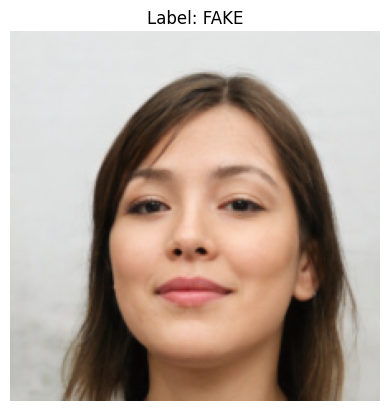

In [ ]:
trainer.train()


In [ ]:
trainer.save_model("./vit-ai-face-detector")
processor.save_pretrained("./vit-ai-face-detector")
